<a href="https://colab.research.google.com/github/ckj241/quantumfinance/blob/master/Calculate_QPL_200826.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
### Data

aapl = pd.read_csv('https://raw.githubusercontent.com/ckj241/quantumfinance/master/AAPL_120824_200824.csv')
tsla = pd.read_csv('https://raw.githubusercontent.com/ckj241/quantumfinance/master/TSLA_120824_200824.csv')
usdhkd = pd.read_csv('https://raw.githubusercontent.com/ckj241/quantumfinance/master/USDHKD_120824_200824.csv')
usdkrw = pd.read_csv('https://raw.githubusercontent.com/ckj241/quantumfinance/master/USDKRW_120824_200824.csv')
eurdkk = pd.read_csv('https://raw.githubusercontent.com/ckj241/quantumfinance/master/EURDKK_120824_200824.csv')
dowf = pd.read_csv('https://raw.githubusercontent.com/ckj241/quantumfinance/master/Dow_F_120824_200824.csv')
nasf = pd.read_csv('https://raw.githubusercontent.com/ckj241/quantumfinance/master/Nasdaq_F_120824_200824.csv')
snpf = pd.read_csv('https://raw.githubusercontent.com/ckj241/quantumfinance/master/SnP_F_120824_200824.csv')
eurusd = pd.read_csv('https://raw.githubusercontent.com/ckj241/quantumfinance/master/EURUSD_120824_200824.csv')

aapl_open_200824 = 514.79
tsla_open_200824 = 2126.28
usdhkd_open_200825 = 7.7498
usdkrw_open_200825 = 1188.6200
eurdkk_open_200825 = 7.4425
eurusd_open_200825 = 1.1801
dowf_open_200824 = 27932.00
nasf_open_200824 = 11605.00 
snpf_open_200824 = 3401.00



In [47]:
class Quantize:
  def __init__(self, data, name, present):
    self.data = data
    self.name = name
    self.open_price = present
    self.df = pd.DataFrame(self.data).set_index('Date').dropna()
    self.oc = self.df['Open']/self.df['Close']
    self.rate = np.array(self.oc)
    self.dif = np.max(self.rate) - np.min(self.rate)
    self.std = np.std(self.rate)
    self.intv = int(round((self.dif * 50)/(3*self.std), 0))
    self.x = np.linspace(np.min(self.rate), np.max(self.rate), self.intv)
    self.y = np.zeros(self.intv)
    for r in self.rate:
      j = 0
      while j < len(self.x):
        if self.x[len(self.x)-1] <= r:
          self.y[len(self.x)-1] += 1/(len(self.rate))
          break
        if r >= self.x[j] and r < self.x[j+1]:
          self.y[j] += 1/(len(self.rate))
        j += 1
  ## Drawing a wave function
  def wave_eq(self):
    plt.plot(self.x, self.y, label = self.name)
    plt.title('wave equation', pad = 10)
    plt.legend(loc='upper right') 
    plt.show()

  ## Calculating a lambda to solve the schrodinger equation
  def calculate_lambda(self):
    self.base = list(self.y).index(np.max(self.y))
    self.gs = self.x[self.base]
    self.uf = self.x[self.base + 1]
    self.df = self.x[self.base - 1]
    self.wave_gs = self.y[self.base]
    self.wave_uf = self.y[self.base + 1]
    self.wave_df = self.y[self.base - 1]
    self.numerator = (np.power(self.df, 2) * self.wave_df) - (np.power(self.uf, 2) * self.wave_uf)
    self.denominator = (np.power(self.uf, 4) * self.wave_uf) - (np.power(self.df, 4) * self.wave_df)
    self.lam = np.abs(self.numerator / self.denominator)
  
  ## Solving the schrodinger equation and Calculating K, QPEL, QPR, NQPR, QPL)
  def solve_se(self):
    from sympy import Symbol, solve
    self.k_n = np.zeros(21)
    self.e_n = np.zeros(21)
    self.qpr_n = np.zeros(21)
    self.nqpr_n = np.zeros(21)
    self.qpl_zero = np.zeros(1)
    self.qpl_positive = np.zeros(20)
    self.qpl_negative = np.zeros(20)
    
    #K0(n)
    for x in range(21):
      numer = (1.1924 + 33.2383 * x + 56.2169 * np.power(x, 2))
      denom = (1 + 43.6196 * x)
      self.k_n[x] = np.cbrt(numer/denom)

    #E(n)
    for y in range(21):
      e = Symbol('x')
      base = e / (2*y + 1)
      third_term = np.power(self.k_n[y], 3) * self.lam
      equation = (base ** 3) - base - third_term
      self.e_n[y] = solve(equation)[0]

    #QPR(n)
    for z in range(21):
      self.qpr_n[z] = self.e_n[z] / self.e_n[0]

    #NQPR(n)
    for a in range(21):
      self.nqpr_n[a] = 1 + (0.21 * self.std * self.qpr_n[a])
    
    #QPL(0)
    self.qpl_zero[0] = self.open_price * self.nqpr_n[0]

    #QPL(+n), QPL(-n)
    for p in range(20):
      self.qpl_positive[p] = self.open_price * self.nqpr_n[p+1]
      self.qpl_negative[p] = self.open_price / self.nqpr_n[p+1]
    
    self.qpl_positive = (np.insert(self.qpl_positive, 0, self.qpl_zero[0], axis=0))
    self.qpl_negative = (np.insert(self.qpl_negative, 0, self.qpl_zero[0], axis=0))
  
  ## Setting a dataframe for the data
  def set_dataframe(self):
    Energy = np.arange(21)
    self.temp = np.array([self.e_n, self.qpr_n, self.nqpr_n, 
                          self.qpl_positive, self.qpl_negative])
    self.result_df = pd.DataFrame(np.transpose(self.temp), 
                                  columns=['QPE', 'QPR', 'NQPR', 'QPL_Positive', 'QPL_Negative'])
    print(self.result_df)

    

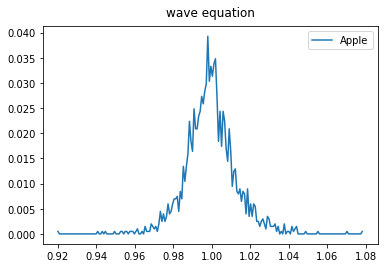

           QPE        QPR      NQPR  QPL_Positive  QPL_Negative
0     1.331868   1.000000  1.002765    516.213166    516.213166
1     4.436912   3.331344  1.009210    519.531057    510.092208
2     8.266396   6.206616  1.017159    523.623047    506.105958
3    12.556659   9.427852  1.026064    528.207402    501.713424
4    17.220369  12.929481  1.035744    533.190802    497.024223
5    22.203014  16.670576  1.046087    538.515002    492.110235
6    27.466619  20.622621  1.057012    544.139420    487.023609
7    32.982900  24.764382  1.068463    550.033835    481.804440
8    38.729815  29.079309  1.080391    556.174694    476.484722
9    44.689607  33.554069  1.092762    562.543021    471.090626
10   50.847604  38.177647  1.105544    569.123141    465.643944
11   57.191444  42.940759  1.118712    575.901843    460.163042
12   63.710535  47.835455  1.132244    582.867809    454.663545
13   70.395685  52.854832  1.146120    590.011218    449.158823
14   77.238827  57.992833  1.160324    5

In [49]:
##Apple

ap = Quantize(aapl, 'Apple', aapl_open_200824)
ap.wave_eq()
ap.calculate_lambda()
ap.solve_se()
ap.set_dataframe()



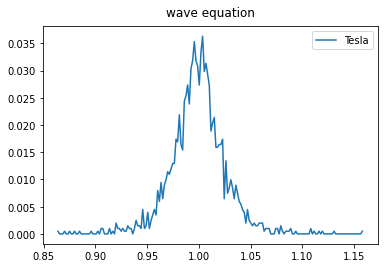

           QPE        QPR      NQPR  QPL_Positive  QPL_Negative
0     1.382883   1.000000  1.005591   2138.168956   2138.168956
1     4.638245   3.354041  1.018754   2166.156045   2087.138020
2     8.687548   6.282201  1.035127   2200.968816   2054.125713
3    13.236141   9.571412  1.053518   2240.074096   2018.266559
4    18.188135  13.152333  1.073540   2282.647514   1980.624083
5    23.484051  16.981953  1.094953   2328.177696   1941.890710
6    29.082592  21.030410  1.117590   2376.309624   1902.557896
7    34.953077  25.275517  1.141326   2426.779510   1862.990280
8    41.071632  29.700010  1.166066   2479.382109   1823.465057
9    47.419048  34.289999  1.191730   2533.952285   1784.195648
10   53.979472  39.034019  1.218256   2590.353736   1745.347200
11   60.739553  43.922417  1.245589   2648.471678   1707.047380
12   67.687862  48.946927  1.273684   2708.207864   1669.394251
13   74.814486  54.100382  1.302499   2769.477063   1632.462207
14   82.110727  59.376492  1.332000   28

In [50]:
##Tesla

ts = Quantize(tsla, 'Tesla', tsla_open_200824)
ts.wave_eq()
ts.calculate_lambda()
ts.solve_se()
ts.set_dataframe()

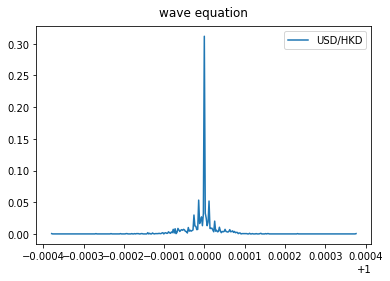

           QPE        QPR      NQPR  QPL_Positive  QPL_Negative
0     1.367901   1.000000  1.000008      7.749863      7.749863
1     4.579366   3.347733  1.000027      7.750012      7.749588
2     8.564748   6.261236  1.000051      7.750196      7.749404
3    13.038324   9.531631  1.000078      7.750403      7.749197
4    17.906664  13.090618  1.000107      7.750628      7.748972
5    23.111716  16.895757  1.000138      7.750869      7.748731
6    28.613141  20.917558  1.000171      7.751124      7.748477
7    34.380946  25.134096  1.000205      7.751390      7.748210
8    40.391786  29.528305  1.000241      7.751668      7.747932
9    46.626871  34.086446  1.000278      7.751957      7.747644
10   53.070688  38.797181  1.000317      7.752255      7.747346
11   59.710171  43.650957  1.000356      7.752562      7.747039
12   66.534133  48.639596  1.000397      7.752878      7.746723
13   73.532869  53.756003  1.000439      7.753202      7.746400
14   80.697863  58.993952  1.000482     

In [51]:
##USDHKD

uh = Quantize(usdhkd, 'USD/HKD', usdhkd_open_200825)
uh.wave_eq()
uh.calculate_lambda()
uh.solve_se()
uh.set_dataframe()

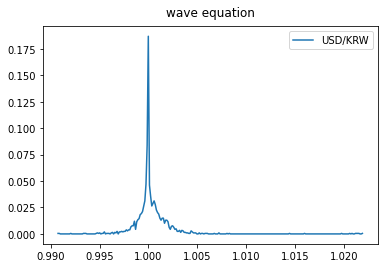

           QPE        QPR      NQPR  QPL_Positive  QPL_Negative
0     1.368278   1.000000  1.000412   1189.110287   1189.110287
1     4.580850   3.347895  1.001381   1190.261430   1186.980834
2     8.567848   6.261775  1.002583   1191.690068   1185.557841
3    13.043320   9.532656  1.003932   1193.293738   1183.964567
4    17.913776  13.092207  1.005400   1195.038940   1182.235538
5    23.121126  16.897977  1.006970   1196.904860   1180.392487
6    28.625007  20.920465  1.008629   1198.877034   1178.450720
7    34.395409  25.137740  1.010369   1200.944710   1176.421773
8    40.408974  29.532728  1.012182   1203.099516   1174.314748
9    46.646901  34.091691  1.014062   1205.334716   1172.137071
10   53.093668  38.803284  1.016006   1207.644750   1169.894959
11   59.736202  43.657952  1.018008   1210.024931   1167.593715
12   66.563311  48.647515  1.020066   1212.471249   1165.237943
13   73.565283  53.764877  1.022177   1214.980226   1162.831686
14   80.733598  59.003809  1.024338   12

In [53]:
###USDKRW

uk = Quantize(usdkrw, 'USD/KRW', usdkrw_open_200825)
uk.wave_eq()
uk.calculate_lambda()
uk.solve_se()
uk.set_dataframe()


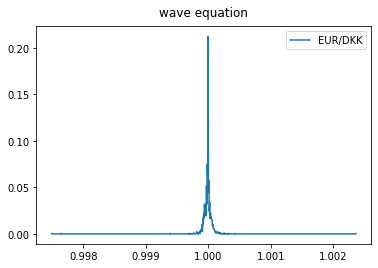

           QPE        QPR      NQPR  QPL_Positive  QPL_Negative
0     1.368084   1.000000  1.000022      7.442667      7.442667
1     4.580087   3.347812  1.000075      7.443059      7.441941
2     8.566254   6.261498  1.000140      7.443545      7.441455
3    13.040751   9.532129  1.000214      7.444091      7.440909
4    17.910118  13.091390  1.000294      7.444685      7.440316
5    23.116286  16.896836  1.000379      7.445320      7.439681
6    28.618904  20.918970  1.000469      7.445992      7.439010
7    34.387970  25.135866  1.000564      7.446695      7.438307
8    40.400134  29.530454  1.000662      7.447429      7.437574
9    46.636599  34.088994  1.000765      7.448190      7.436814
10   53.081849  38.800146  1.000870      7.448976      7.436029
11   59.722814  43.654355  1.000979      7.449786      7.435221
12   66.548304  48.643443  1.001091      7.450619      7.434390
13   73.548612  53.760314  1.001206      7.451473      7.433538
14   80.715218  58.998741  1.001323     

In [55]:
##EURDKK

ed = Quantize(eurdkk, 'EUR/DKK', eurdkk_open_200825)
ed.wave_eq()
ed.calculate_lambda()
ed.solve_se()
ed.set_dataframe()


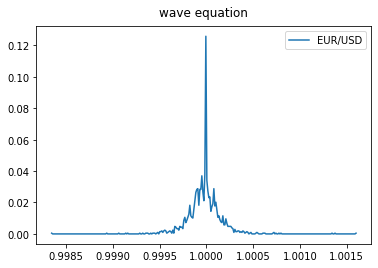

           QPE        QPR      NQPR  QPL_Positive  QPL_Negative
0     1.368170   1.000000  1.000037      1.180144      1.180144
1     4.580424   3.347849  1.000125      1.180248      1.179952
2     8.566959   6.261621  1.000234      1.180376      1.179824
3    13.041887   9.532362  1.000356      1.180520      1.179680
4    17.911736  13.091752  1.000489      1.180677      1.179523
5    23.118427  16.897341  1.000631      1.180845      1.179355
6    28.621603  20.919632  1.000782      1.181022      1.179178
7    34.391260  25.136695  1.000939      1.181208      1.178993
8    40.404044  29.531460  1.001103      1.181402      1.178799
9    46.641155  34.090187  1.001274      1.181603      1.178599
10   53.087077  38.801534  1.001450      1.181811      1.178392
11   59.728736  43.655946  1.001631      1.182025      1.178178
12   66.554942  48.645244  1.001818      1.182245      1.177959
13   73.555985  53.762332  1.002009      1.182471      1.177734
14   80.723347  59.000983  1.002205     

In [56]:
### EURUSD

eu = Quantize(eurusd, 'EUR/USD', eurusd_open_200825)
eu.wave_eq()
eu.calculate_lambda()
eu.solve_se()
eu.set_dataframe()


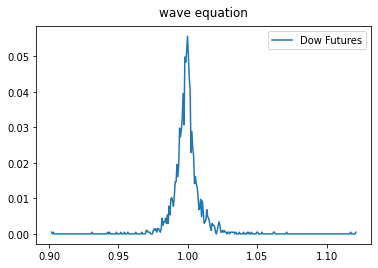

           QPE        QPR      NQPR  QPL_Positive  QPL_Negative
0     1.412539   1.000000  1.002207  27993.651207  27993.651207
1     4.754245   3.365746  1.007429  28139.502286  27726.027848
2     8.928690   6.321024  1.013952  28321.698762  27547.663385
3    13.623935   9.645001  1.021288  28526.625948  27349.768788
4    18.739343  13.266430  1.029282  28749.891407  27137.376380
5    24.212667  17.141243  1.037834  28988.778351  26913.746228
6    30.000763  21.238899  1.046878  29241.403747  26681.230174
7    36.071609  25.536726  1.056364  29506.369972  26441.633611
8    42.400309  30.017099  1.066253  29782.590411  26196.399078
9    48.966844  34.665847  1.076514  30069.191300  25946.711244
10   55.754697  39.471275  1.087121  30365.451785  25693.562195
11   62.749965  44.423542  1.098051  30670.765032  25437.794695
12   69.940751  49.514225  1.109287  30984.611788  25180.132297
13   77.316737  54.736020  1.120813  31306.541713  24921.201171
14   84.868872  60.082518  1.132613  316

In [57]:
## Dow Futures

d_F = Quantize(dowf, 'Dow Futures', dowf_open_200824)
d_F.wave_eq()
d_F.calculate_lambda()
d_F.solve_se()
d_F.set_dataframe()


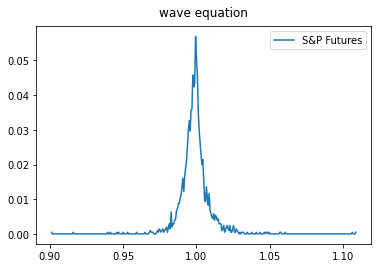

           QPE        QPR      NQPR  QPL_Positive  QPL_Negative
0     1.364326   1.000000  1.002160   3408.344593   3408.344593
1     4.565287   3.346186  1.007226   3425.576373   3376.599947
2     8.535343   6.256089  1.013510   3446.948429   3355.664071
3    12.990920   9.521861  1.020563   3470.934199   3332.474872
4    17.839181  13.075457  1.028237   3497.033910   3307.603329
5    23.022419  16.874578  1.036441   3524.936908   3281.420718
6    28.500524  20.889826  1.045112   3554.427270   3254.195436
7    34.243672  25.099340  1.054203   3585.344439   3226.133834
8    40.228644  29.486101  1.063676   3617.563419   3197.401029
9    46.436749  34.036412  1.073503   3650.983602   3168.132827
10   52.852559  38.738962  1.083658   3685.521919   3138.443144
11   59.463074  43.584224  1.094122   3721.108398   3108.428931
12   66.257167  48.564042  1.104876   3757.683132   3078.173596
13   73.225182  53.671338  1.115905   3795.194145   3047.749485
14   80.358647  58.899903  1.127197   38

In [58]:
## S&P 500 Futures

s_F = Quantize(snpf, 'S&P Futures', snpf_open_200824)
s_F.wave_eq()
s_F.calculate_lambda()
s_F.solve_se()
s_F.set_dataframe()


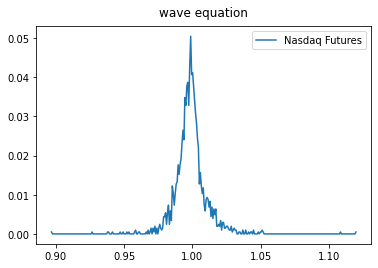

           QPE        QPR      NQPR  QPL_Positive  QPL_Negative
0     1.386109   1.000000  1.002471  11633.672687  11633.672687
1     4.650899   3.355363  1.008290  11701.207283  11509.583733
2     8.713902   6.286593  1.015532  11785.253502  11427.503446
3    13.278564   9.579740  1.023669  11879.676899  11336.674065
4    18.248471  13.165251  1.032528  11982.483112  11239.408705
5    23.563839  16.999991  1.042002  12092.435428  11137.212665
6    29.183169  21.054023  1.052019  12208.675423  11031.174172
7    35.075631  25.305105  1.062522  12330.565349  10922.128968
8    41.217239  29.735931  1.073469  12457.609038  10810.744228
9    47.588694  34.332579  1.084826  12589.407306  10697.566750
10   54.174071  39.083560  1.096564  12725.630694  10583.053071
11   60.959958  43.979197  1.108660  12866.001765  10467.589501
12   67.934874  49.011209  1.121093  13010.283056  10351.506145
13   75.088861  54.172410  1.133845  13158.268573  10235.087105
14   82.413183  59.456499  1.146900  133

In [59]:
## Nasdaq Futures

n_F = Quantize(nasf, 'Nasdaq Futures', nasf_open_200824)
n_F.wave_eq()
n_F.calculate_lambda()
n_F.solve_se()
n_F.set_dataframe()
